In [ ]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import pylab
import pandas as pd
import seaborn as sns
import statistics

In [ ]:
donnees = pd.read_csv("Musique_quant.csv", sep=";").dropna()

In [ ]:
sns.pairplot(data=donnees)

In [ ]:
correlation_matrix = donnees.corr()
plt.figure(figsize=(10, 8))  # Adjust the figure size if needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
def quant_discret(data):
    effectifs = data.value_counts().sort_index()
    population_size = len(data)
    frequences = effectifs / population_size

    min_val = data.min() # Valeur minimale
    max_val = data.max() # Valeur maximale
    moyenne = data.mean() # Moyenne      
    mode = data.mode() # Mode    
    mediane = data.median() # Médiane
    ecart_type = data.std() # Écart-type    
    variance = data.var() # Variance  
    etendue = max_val - min_val  # Étendue
    
    quantiles = data.quantile([0.25, 0.5, 0.75])
    #iqr = quantiles[0] - quantiles[2] # Écart interquartile

    print(data.describe())
    print("mode : ", mode)
    print("médiane : ", mediane)
    print("écart-type : ", ecart_type)
    print("variance : ", variance)
    print("étendue : ", etendue)

    # If any slice of the pie is less than 5%, plot a histogram instead
    if any(frequences < 0.05):
        plt.hist(data, bins='auto')
        plt.title("Histogramme de " + data.name)
        plt.xlabel(data.name)
        plt.ylabel("Effectifs")
        plt.show()
    else:
        effectifs.plot(kind='pie', autopct='%1.1f%%')
        plt.title("Diagramme circulaire de " + data.name)
        plt.ylabel("")
        plt.show()

    sns.ecdfplot(data)
    plt.title("Fonction de répartition empirique de " + data.name)
    plt.xlabel(data.name)
    plt.ylabel("Fréquence cumulée")
    plt.show()

    plt.boxplot(data)
    plt.title("Boxplot de " + data.name)
    plt.xlabel(data.name)
    plt.tight_layout()
    plt.show()


In [ ]:
quant_discret(donnees["Mode"])
quant_discret(donnees["Time Signature"])
quant_discret(donnees["Explicit"])

In [ ]:
def etude_univariee(data, variable_name, K=0):
    print(data[variable_name].describe())
    
    plt.show()
    
    def calculate_bins(data_column, num_classes):
        n = len(data_column)  # Size of the population
        if num_classes == 0:  # If K is not specified by the user
            num_classes = int(np.ceil(1 + np.log2(n)))  # Number of classes according to the Sturges formula
        e = data_column.max() - data_column.min()  # Range
        bins = np.linspace(data_column.min(), data_column.max(), num_classes + 1)  # Bins for distribution
        return bins

    # Calcul des bins pour la variable choisie
    bins = calculate_bins(data[variable_name].dropna(), K)  # Supprimer les NaN pour calculer les bins

    # Assignation des classes aux données
    data[f'{variable_name}_classe'] = pd.cut(data[variable_name], bins=bins, include_lowest=True)

    # Choix d'une palette de couleurs
    palette = sns.color_palette("flare", n_colors=len(bins))

    # Visualisations détaillées pour la variable choisie avec répartition en classes
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Histogramme de la variable avec classes
    sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0], palette=palette)
    ax[0].set_title(f"Histogramme de {variable_name} par classes", fontsize=16)
    ax[0].set_xlabel(f"{variable_name.capitalize()}", fontsize=14)
    ax[0].set_ylabel('Fréquence', fontsize=14)
    
    
    sns.boxplot( data=data[variable_name], palette=palette)

    # Boîte à moustaches pour la variable avec classes
    sns.boxplot(x=f'{variable_name}_classe', y=variable_name, data=data, ax=ax[1], palette=palette)
    ax[1].set_title(f"Boxplot de {variable_name} par classes", fontsize=16)
    ax[1].set_xlabel(f"Classes de {variable_name}", fontsize=14)
    ax[1].set_ylabel(f"{variable_name.capitalize()}", fontsize=14)
    ax[1].tick_params(axis='x', rotation=45) 


    plt.tight_layout()
    plt.show()  
    

In [ ]:
for column in donnees.columns:
    etude_univariee(donnees, column)
    

In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def multivariate_analysis(data, target_variable):
    # Calculate correlations
    correlations = data.corr()[target_variable].drop(target_variable)
    
    # Perform explanatory variable tests
    p_values = []
    for column in data.columns:
        if column != target_variable:
            _, p_value = stats.ttest_ind(data[data[target_variable] == 0][column],
                                         data[data[target_variable] == 1][column])
            p_values.append(p_value)
    
    # Perform PCA
    pca = PCA()
    pca.fit(data.drop(target_variable, axis=1))
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained Variance Ratio:")
    print(explained_variance_ratio)
    loadings = pd.DataFrame(pca.components_.T, columns=["PC" + str(i) for i in range(1, len(pca.components_)+1)], index=data.drop(target_variable, axis=1).columns)
    print("PCA Loadings:")
    print(loadings)
    
    # Plot correlations
    plt.figure(figsize=(10, 6))
    sns.barplot(x=correlations.index, y=correlations.values)
    plt.title(f"Correlations with {target_variable}")
    plt.xlabel("Variable")
    plt.ylabel("Correlation")
    plt.xticks(rotation=45)
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(np.cumsum(explained_variance_ratio))
    plt.title("Explained Variance Ratio")
    plt.xlabel("Number of Principal Components")
    plt.ylabel("Cumulative Explained Variance")
    plt.show()
    
    eig = pd.DataFrame(
    {
        "Dimension" : ["Dim" + str(x + 1) for x in range(len(pca.explained_variance_))], 
        "Variance expliquée" : pca.explained_variance_,
        "% variance expliquée" : np.round(pca.explained_variance_ratio_ * 100),
        "% cum. var. expliquée" : np.round(np.cumsum(pca.explained_variance_ratio_) * 100)
    })
    print(eig)
    
# Call the function with your data and target variable
multivariate_analysis(donnees, "Popularity")


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

def build_and_evaluate_model(data, target_variable):
    # Separate features and target variable
    X = data.drop(target_variable, axis=1)
    y = data[target_variable]

    # Normalize the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform PCA
    pca = PCA(n_components=0.95)  # Retain components explaining at least 95% of variance
    X_pca = pca.fit_transform(X_scaled)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # Initialize and train the model (Random Forest Regression)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict on the testing set
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Mean Squared Error:", mse)
    print("Mean Absolute Error:", mae)
    print("R-squared:", r2)

    # Visualize model performance
    visualize_model_performance(y_test, y_pred)

    # Return the model for further analysis if needed
    return model

def visualize_model_performance(y_test, y_pred):
    # Create scatter plot of actual vs. predicted popularity
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    plt.xlabel('Actual Popularity')
    plt.ylabel('Predicted Popularity')
    plt.title('Actual vs. Predicted Popularity')
    plt.show()

# Call the function with your data and target variable
model = build_and_evaluate_model(donnees, "Popularity")

count    9997.000000
mean      224.825236
std        54.097318
min         0.000000
25%       192.586000
50%       219.920000
75%       250.280000
max      1561.133000
Name: Track_duration(s), dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'{variable_name}_classe', y=variable_na

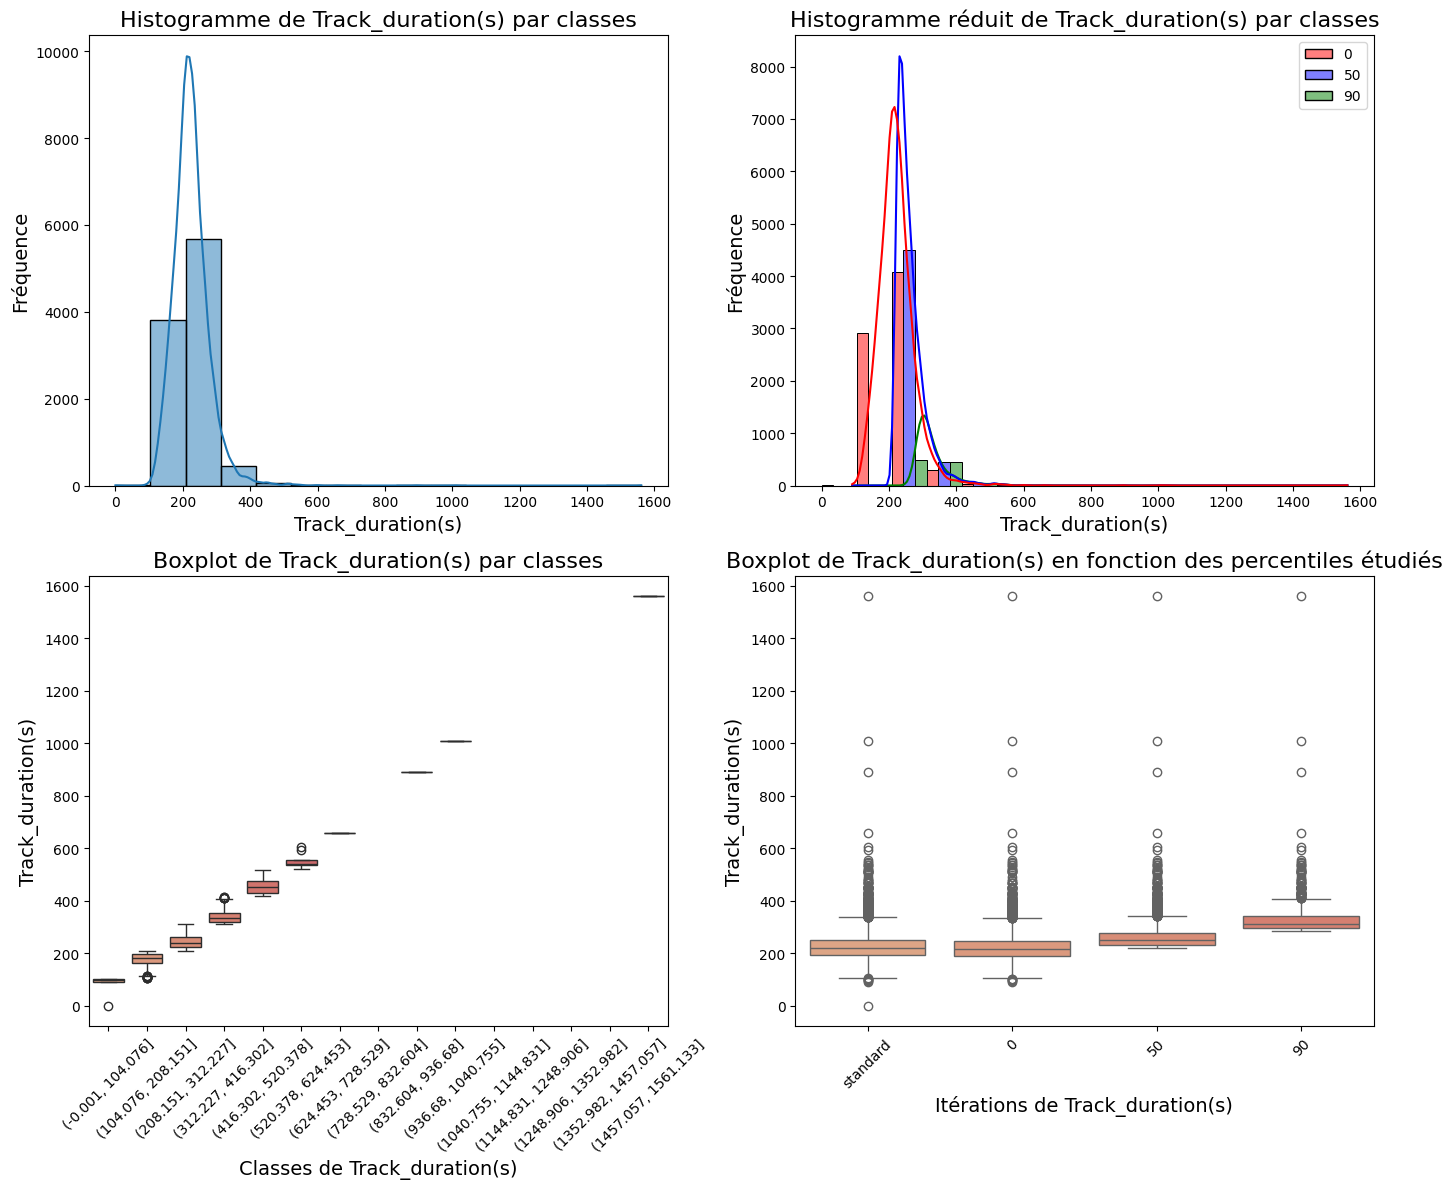

count    9997.000000
mean       37.632190
std        29.458948
min         0.000000
25%         0.000000
50%        42.000000
75%        64.000000
max        98.000000
Name: Popularity, dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'{variable_name}_classe', y=variable_na

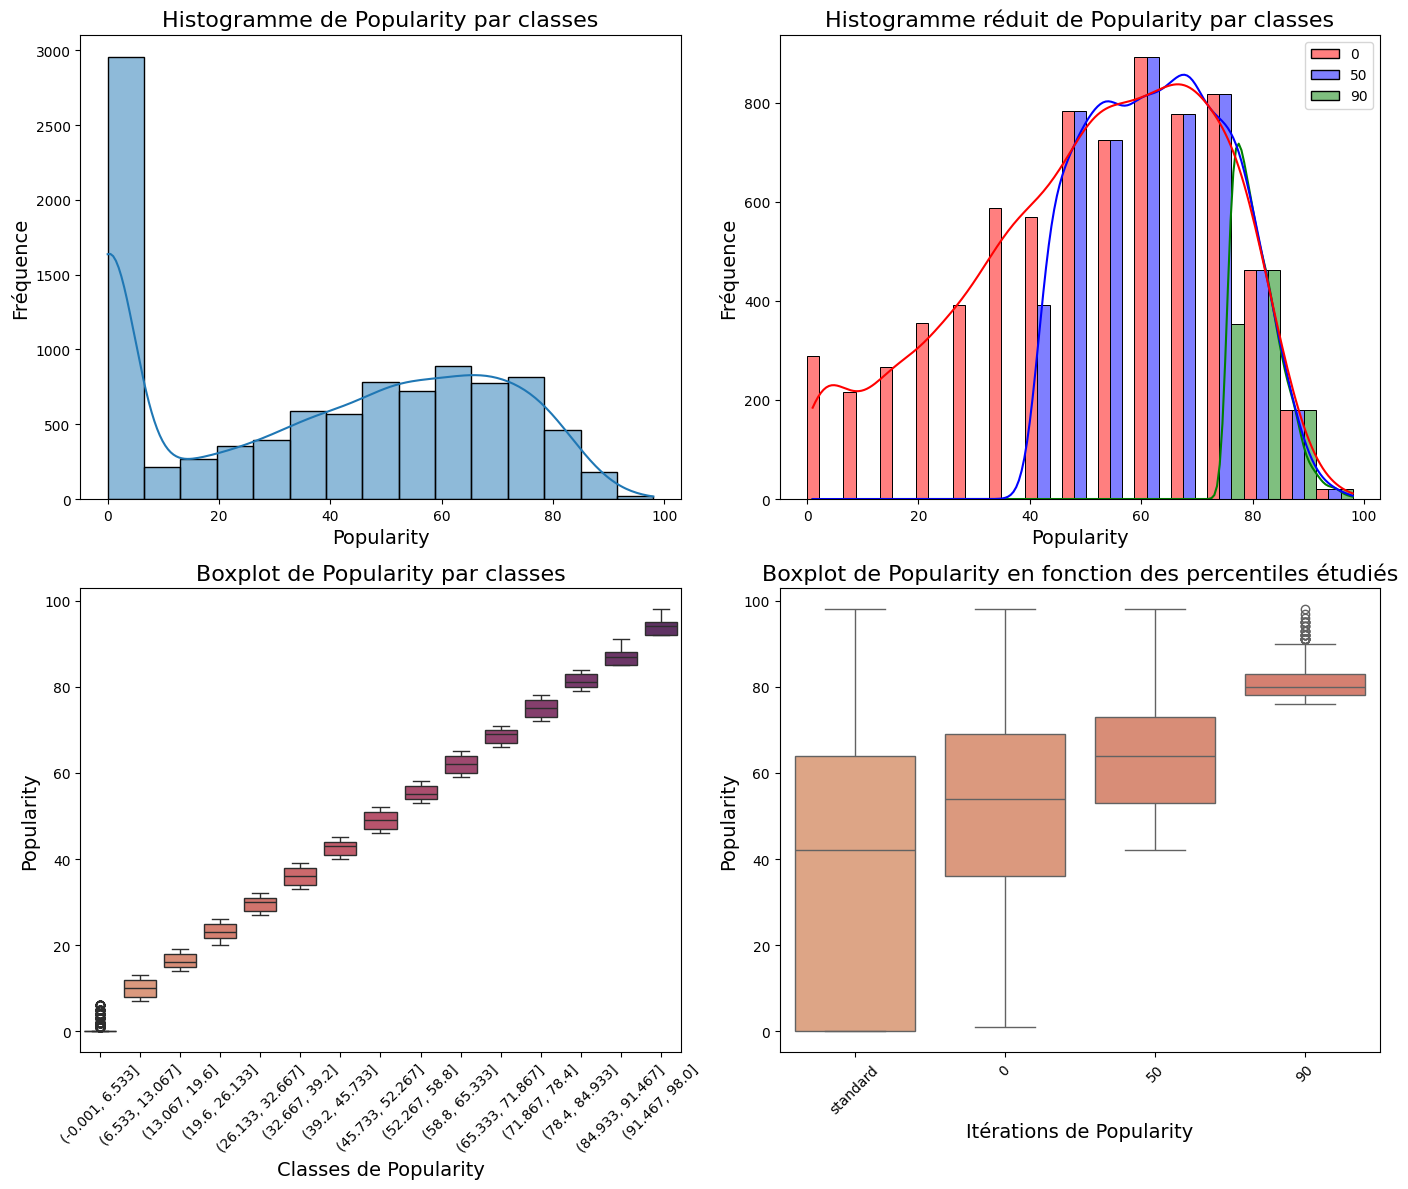

count    9997.000000
mean        0.607925
std         0.145869
min         0.000000
25%         0.515000
50%         0.617000
75%         0.710000
max         0.988000
Name: Danceability, dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'{variable_name}_classe', y=variable_na

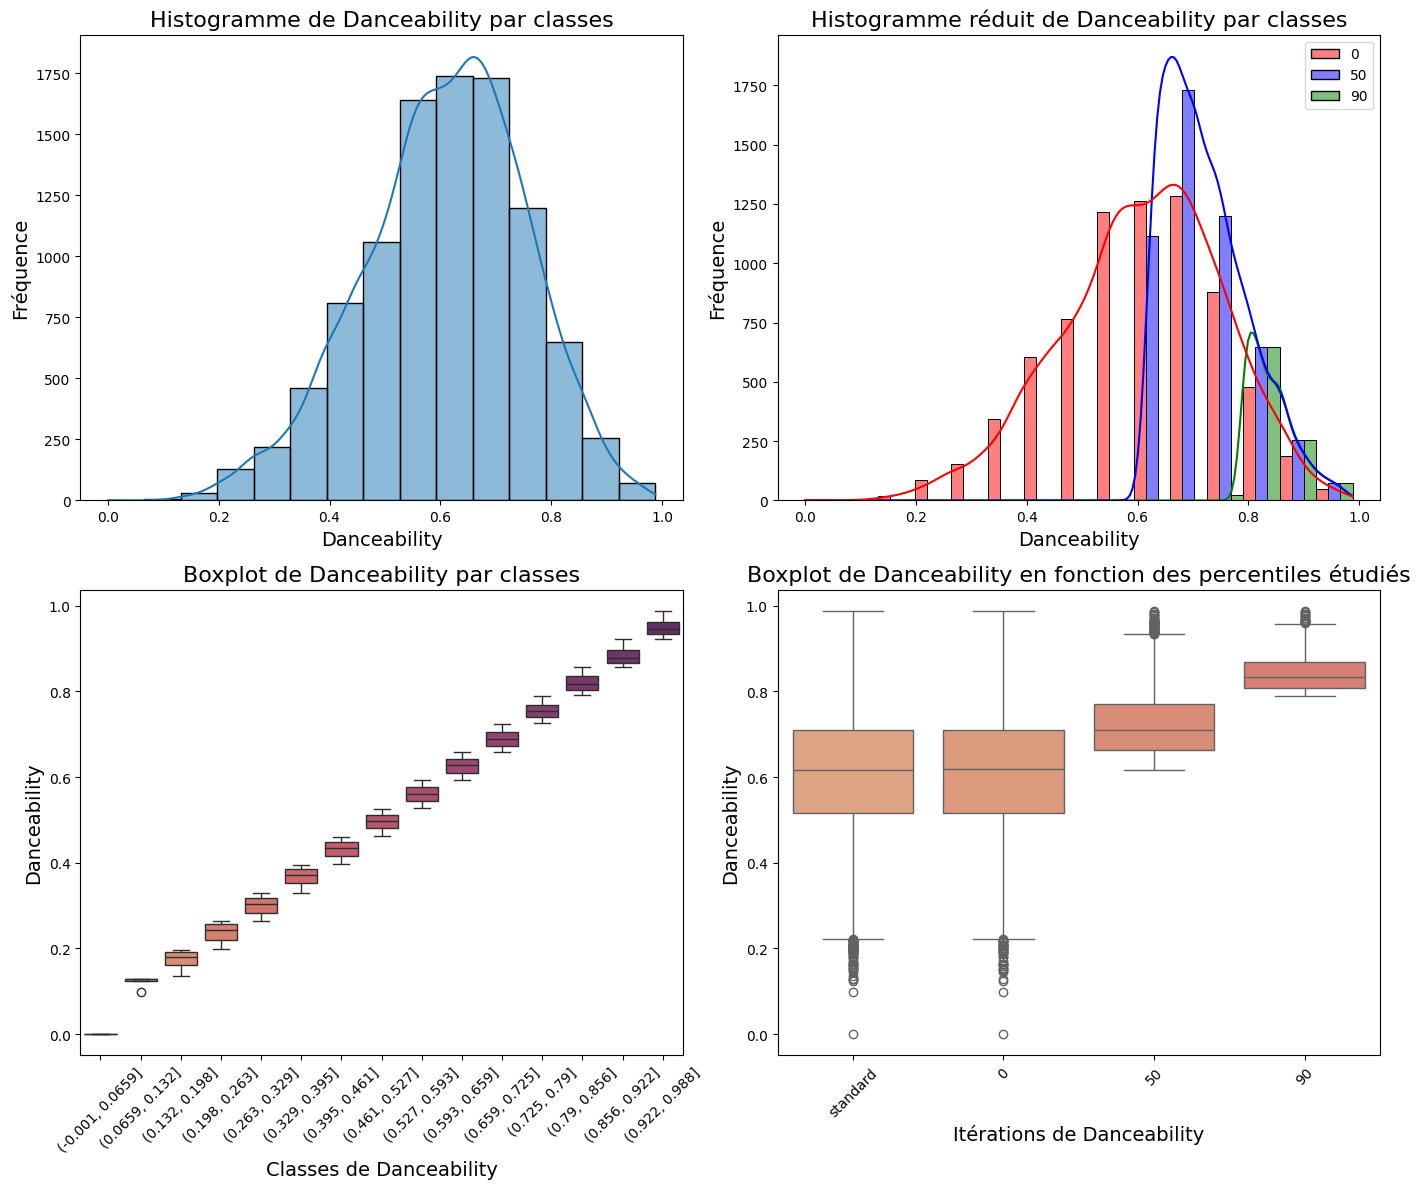

count    9997.000000
mean        0.683281
std         0.191131
min         0.000020
25%         0.560000
50%         0.712000
75%         0.835000
max         0.997000
Name: Energy, dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'{variable_name}_classe', y=variable_na

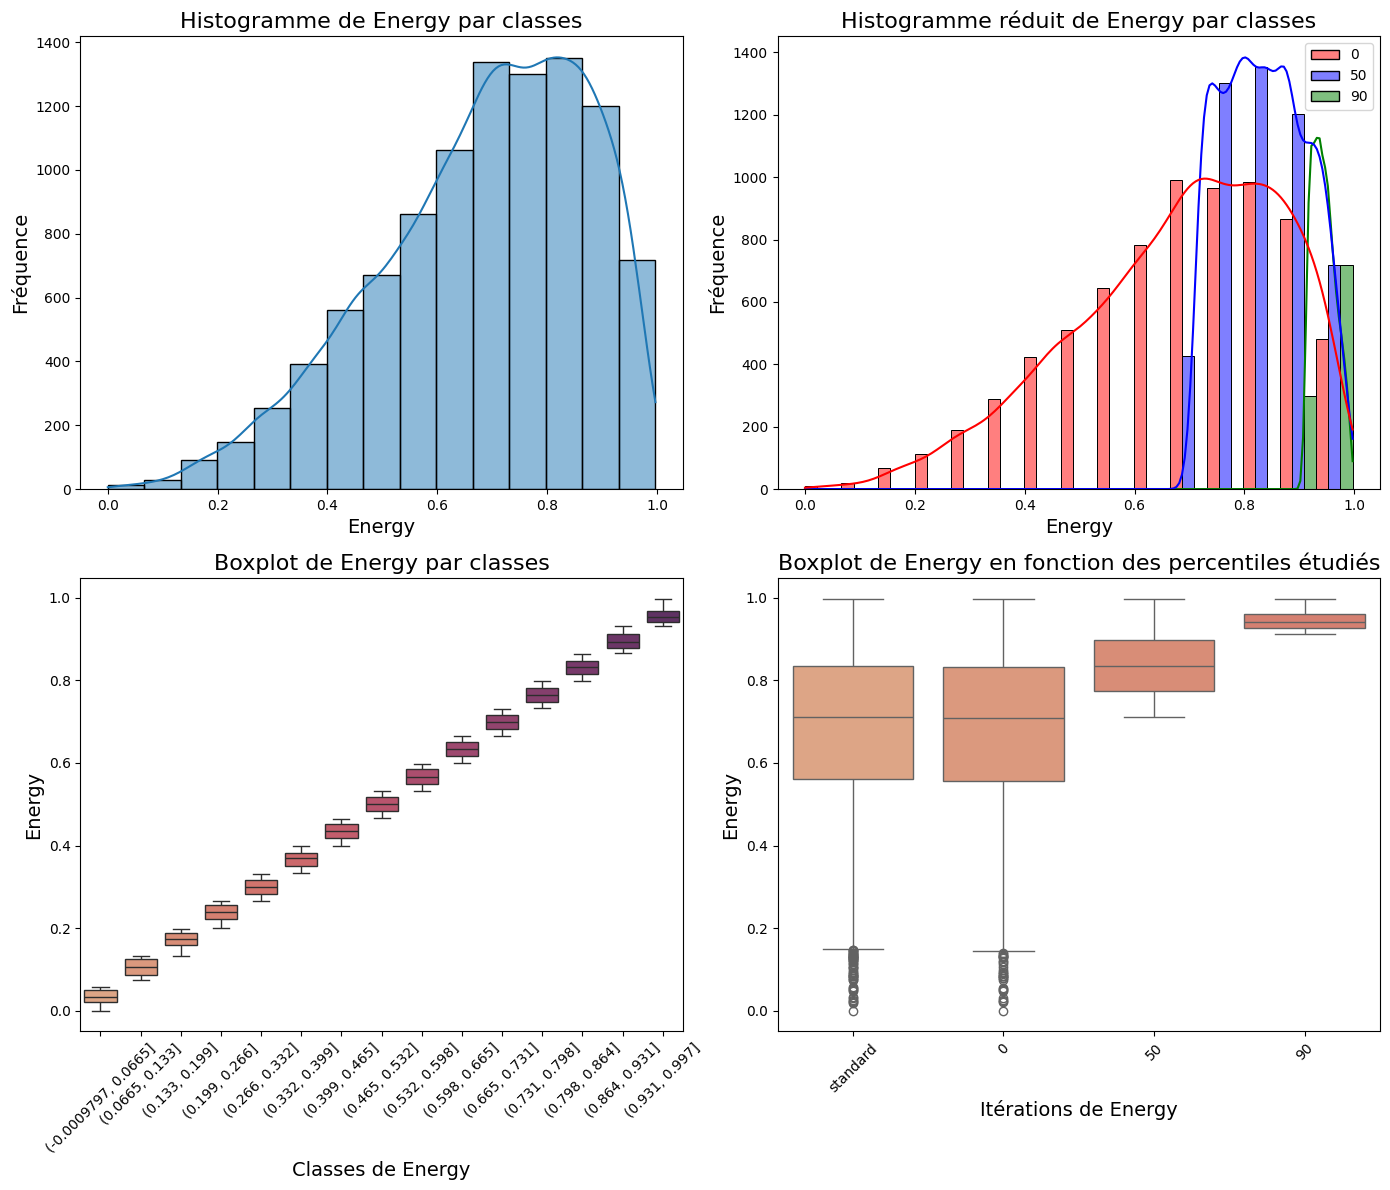

count    9997.000000
mean        5.167750
std         3.578392
min         0.000000
25%         2.000000
50%         5.000000
75%         8.000000
max        11.000000
Name: Key, dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'{variable_name}_classe', y=variable_na

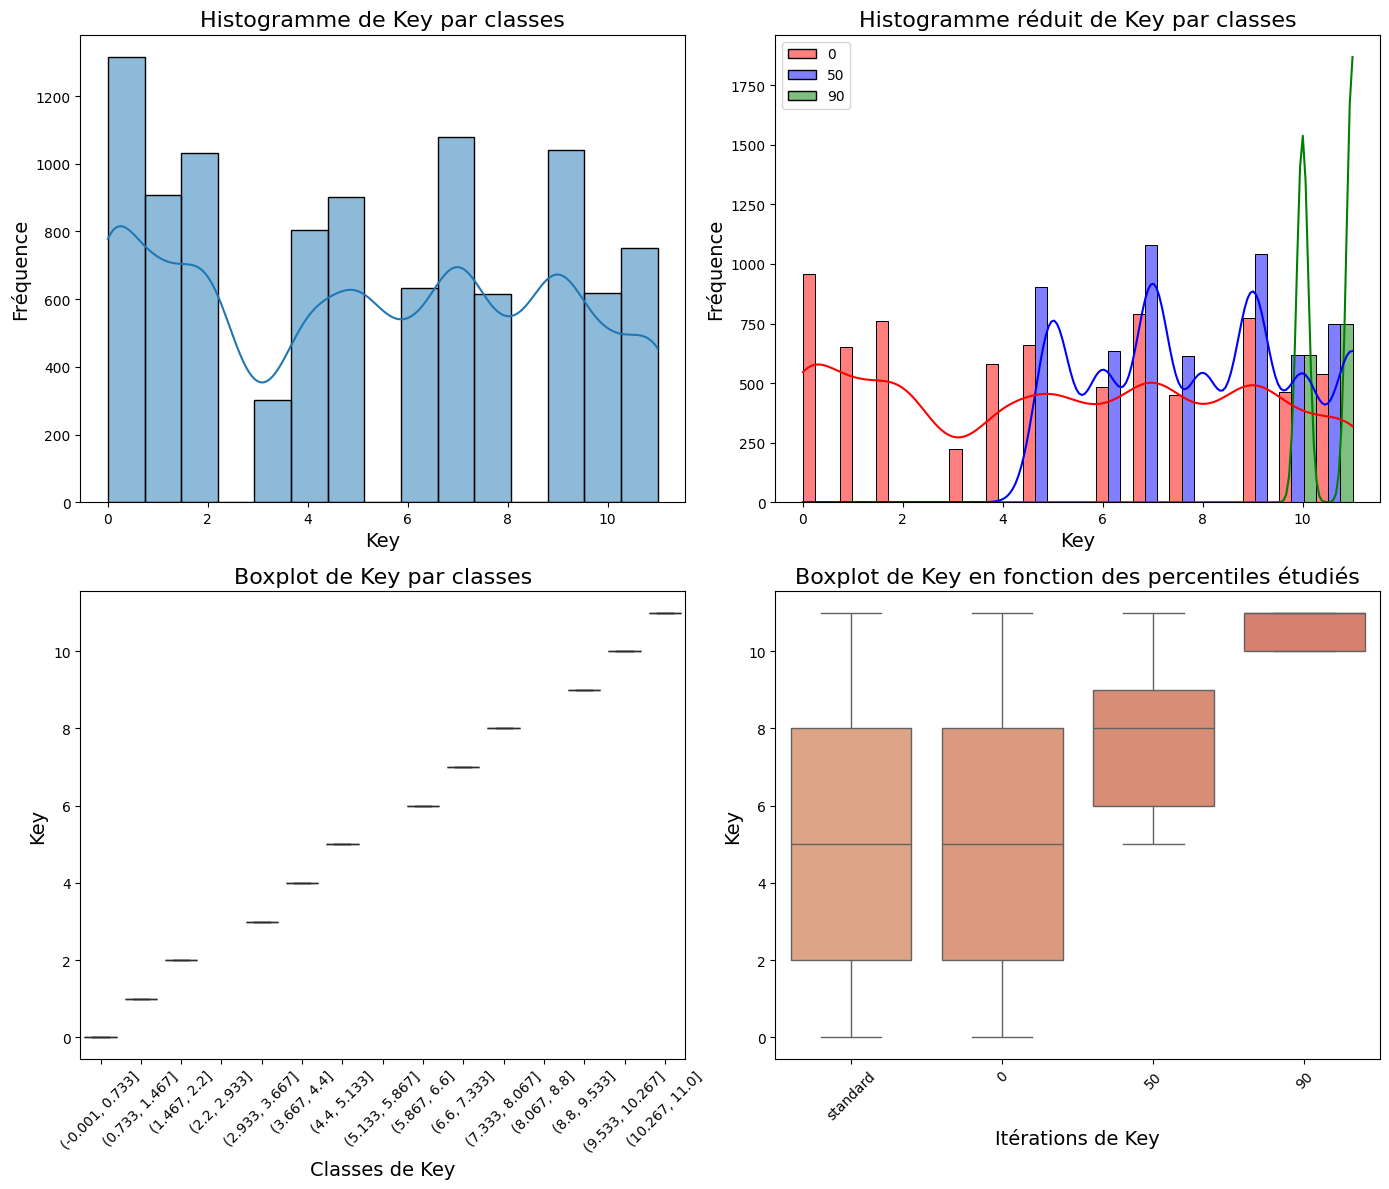

count    9997.000000
mean       -7.269217
std         3.281731
min       -29.368000
25%        -9.070000
50%        -6.518000
75%        -4.887000
max         2.769000
Name: Loudness, dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'{variable_name}_classe', y=variable_na

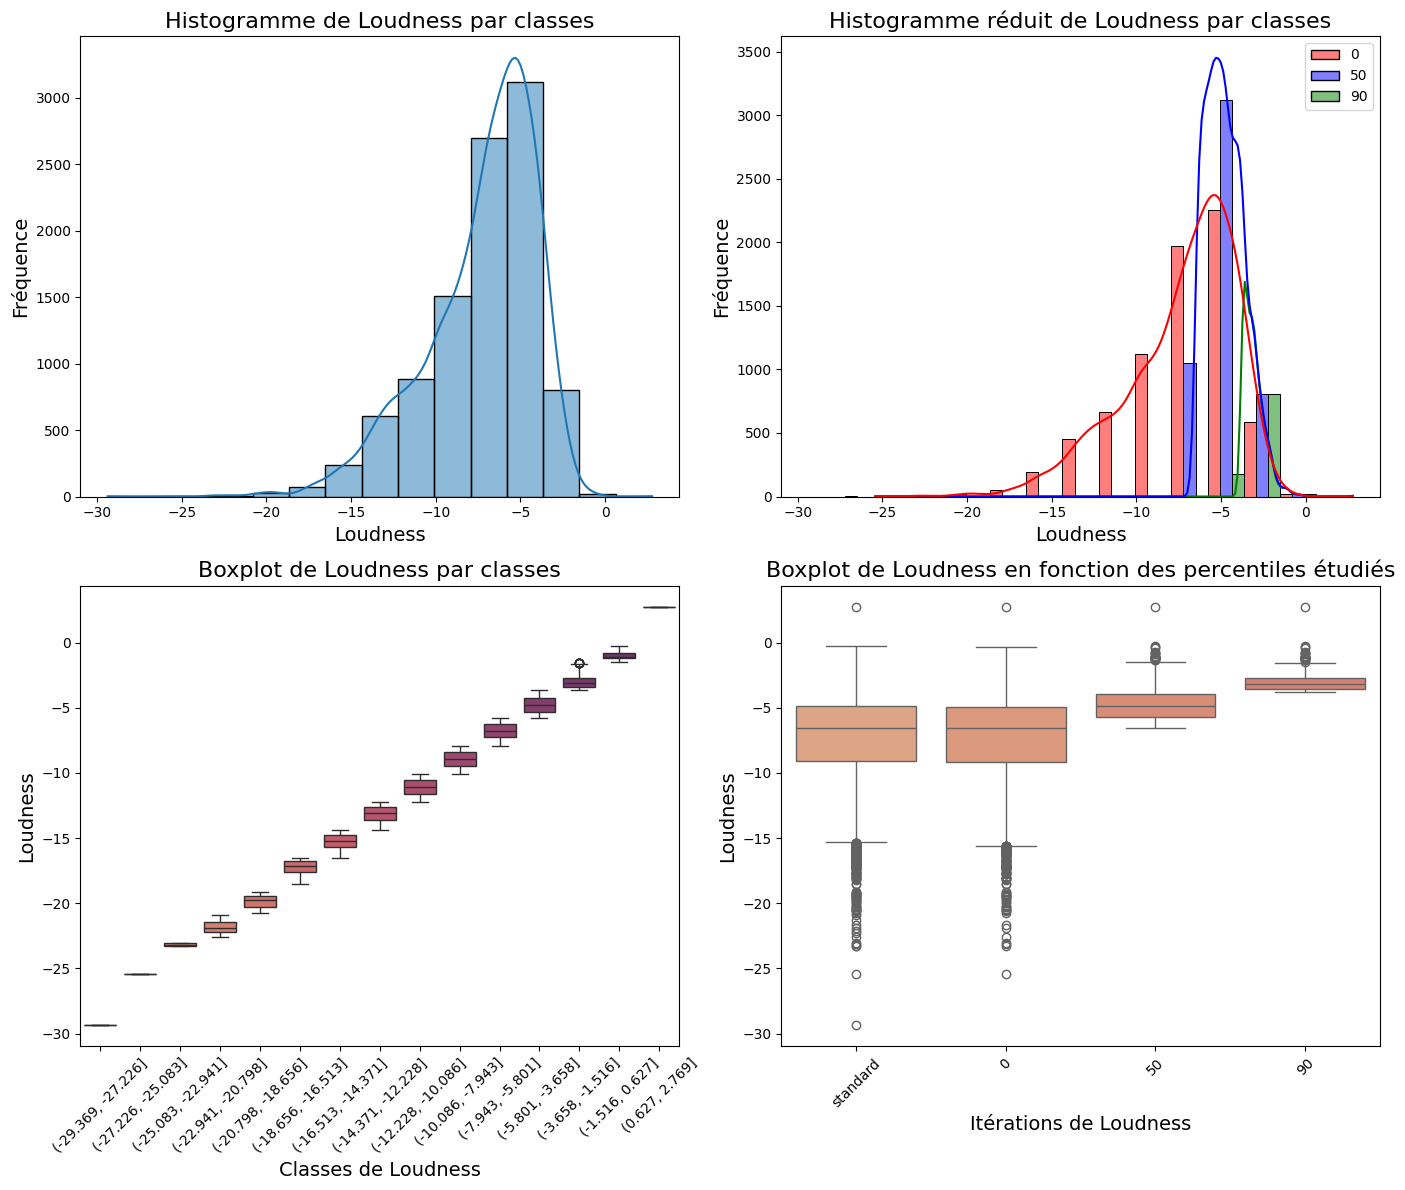

count    9997.000000
mean        0.698410
std         0.458971
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: Mode, dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'{variable_name}_classe', y=variable_na

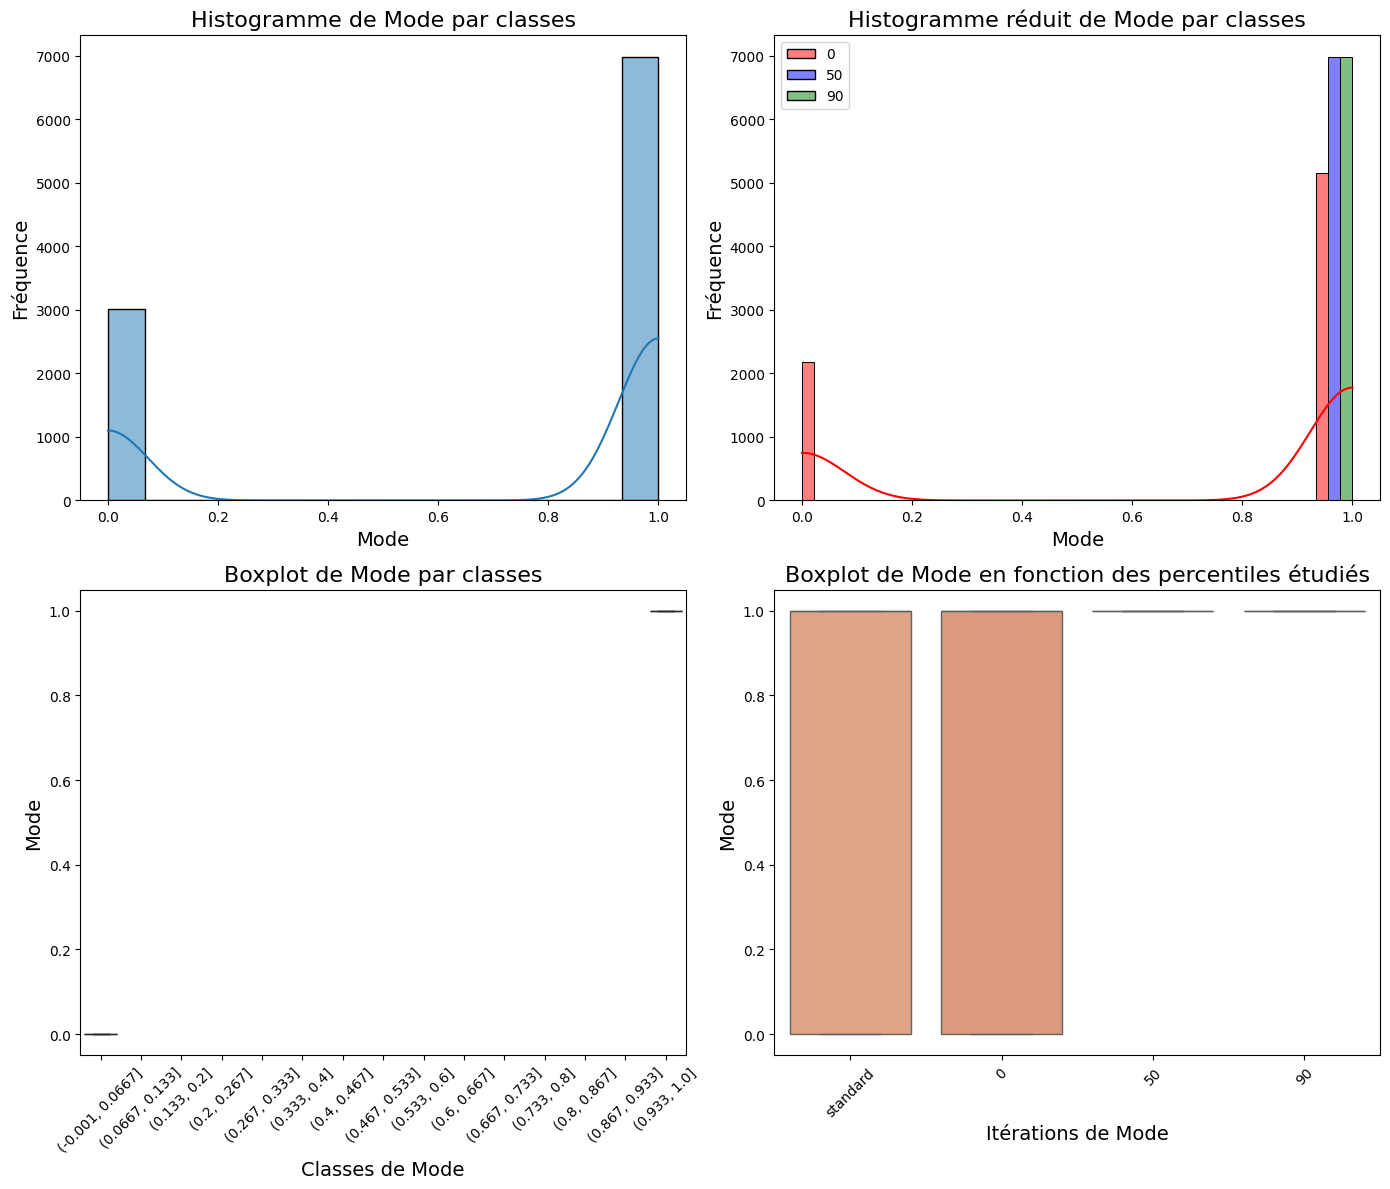

count    9997.000000
mean        0.065138
std         0.061324
min         0.000000
25%         0.033100
50%         0.042900
75%         0.067500
max         0.711000
Name: Speechiness, dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'{variable_name}_classe', y=variable_na

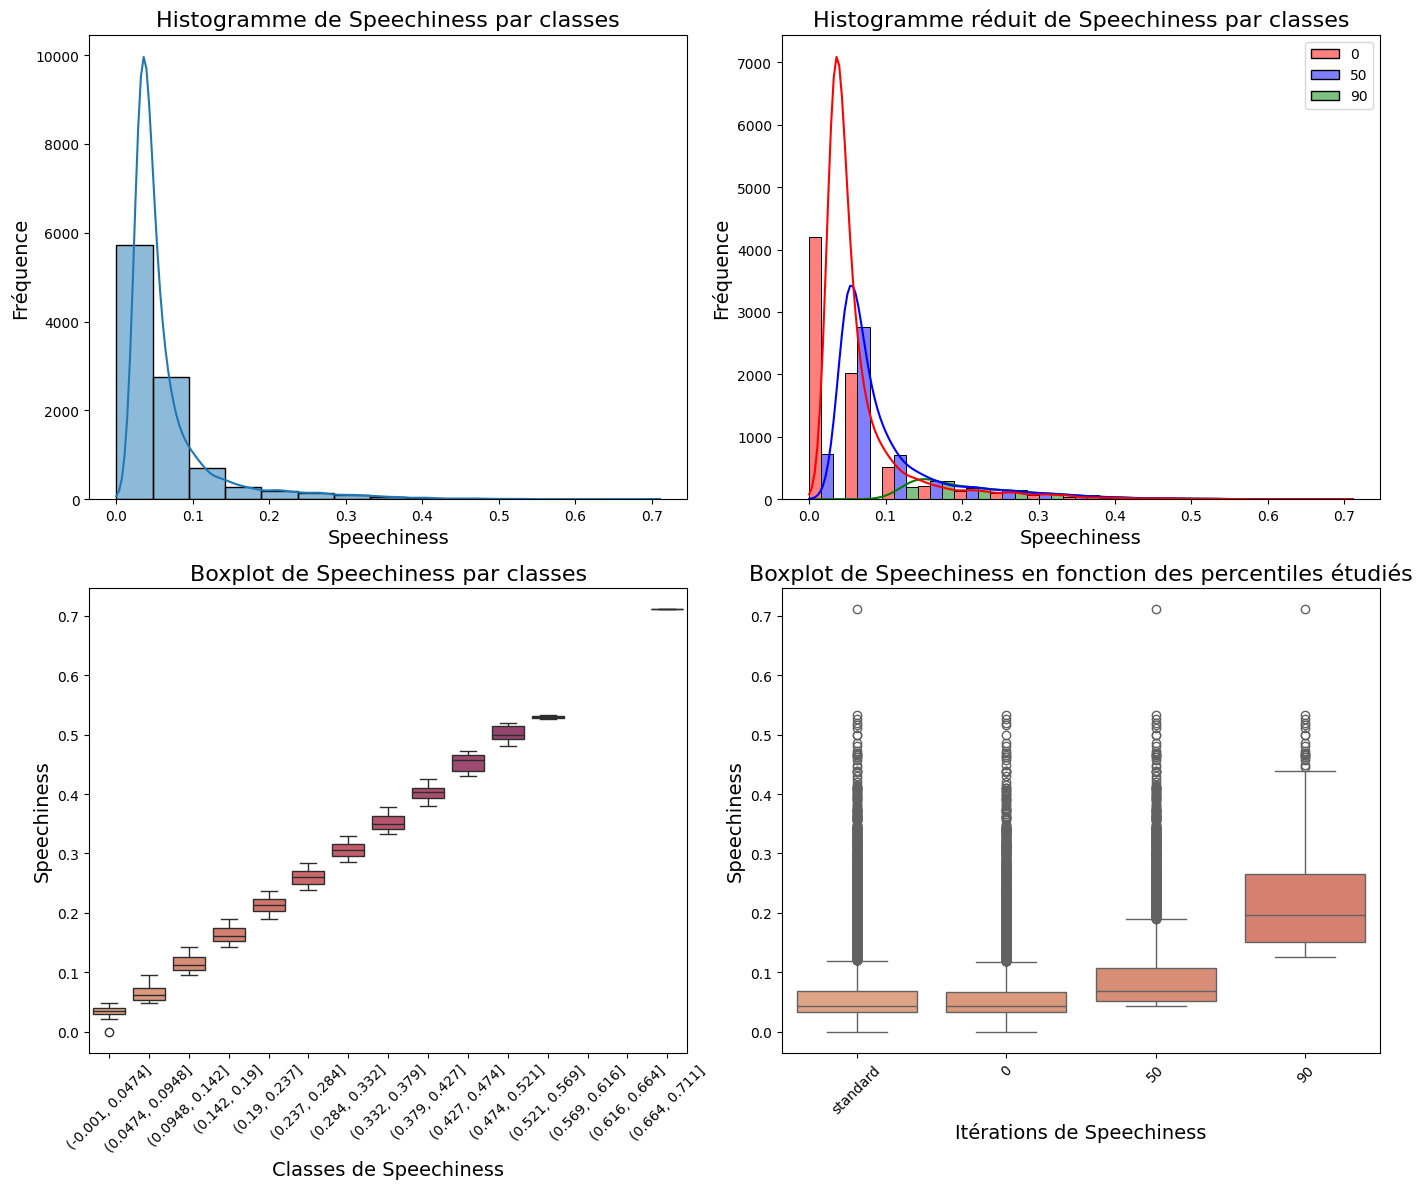

count    9997.000000
mean        0.208589
std         0.248842
min         0.000003
25%         0.018400
50%         0.095600
75%         0.318000
max         0.991000
Name: Acousticness, dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'{variable_name}_classe', y=variable_na

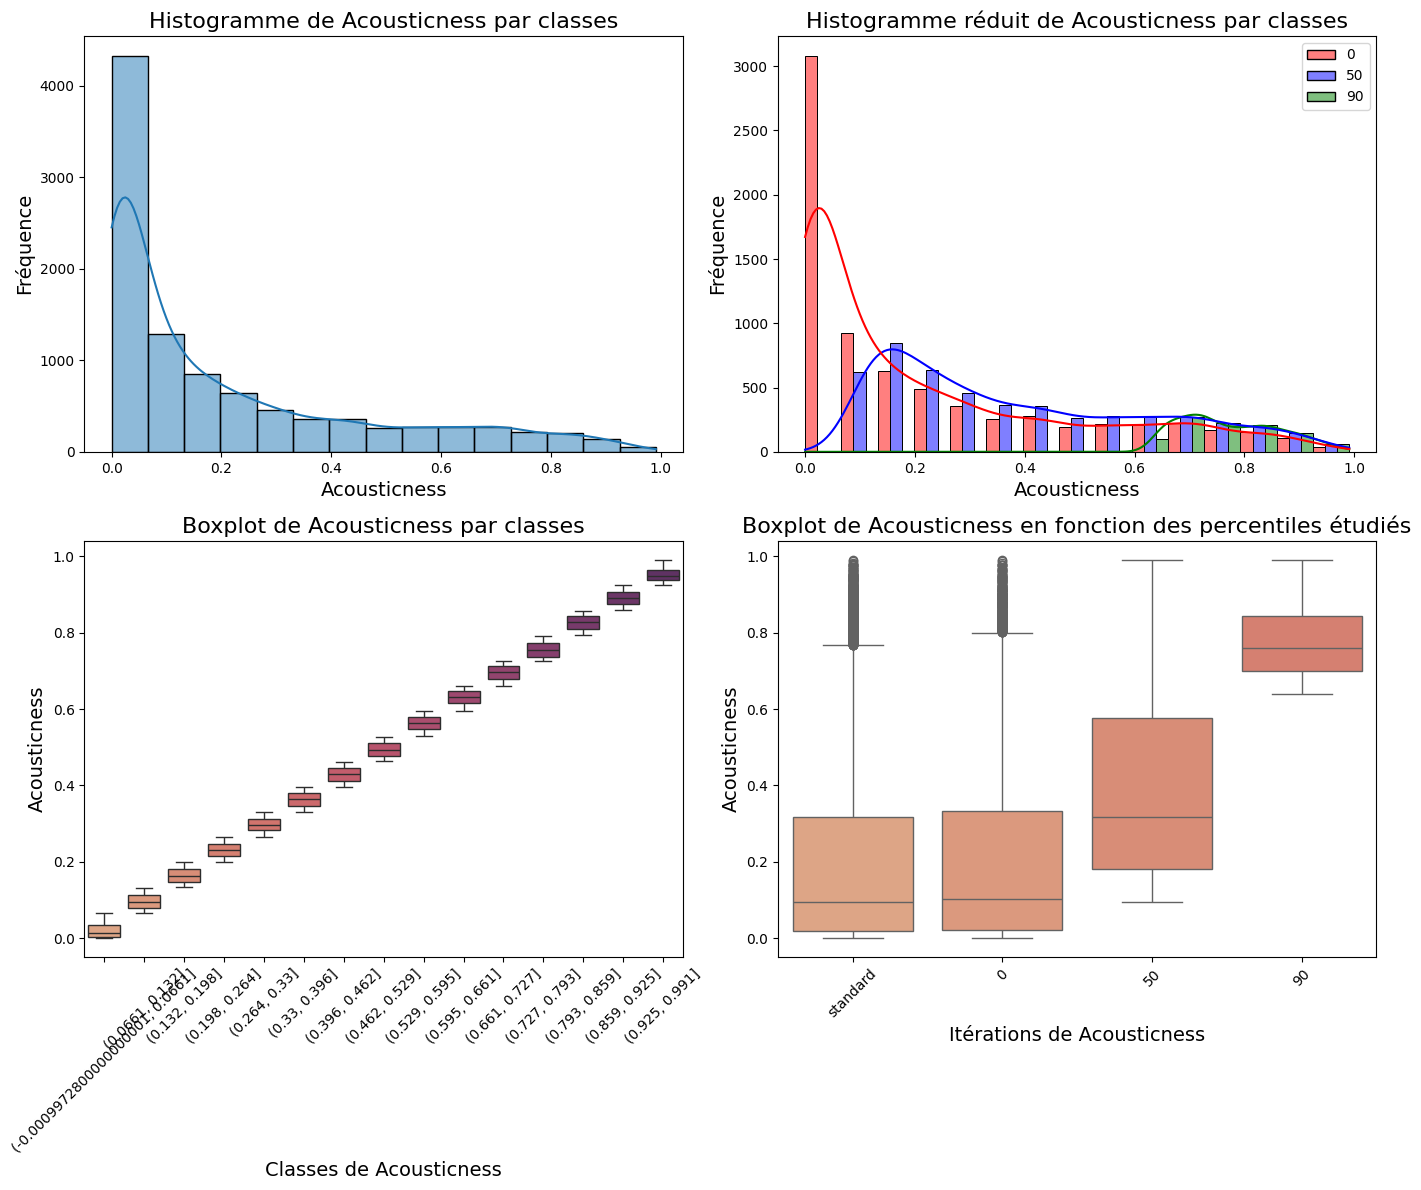

count    9997.000000
mean        0.029331
std         0.123576
min         0.000000
25%         0.000000
50%         0.000006
75%         0.000561
max         0.985000
Name: Instrumentalness, dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'{variable_name}_classe', y=variable_na

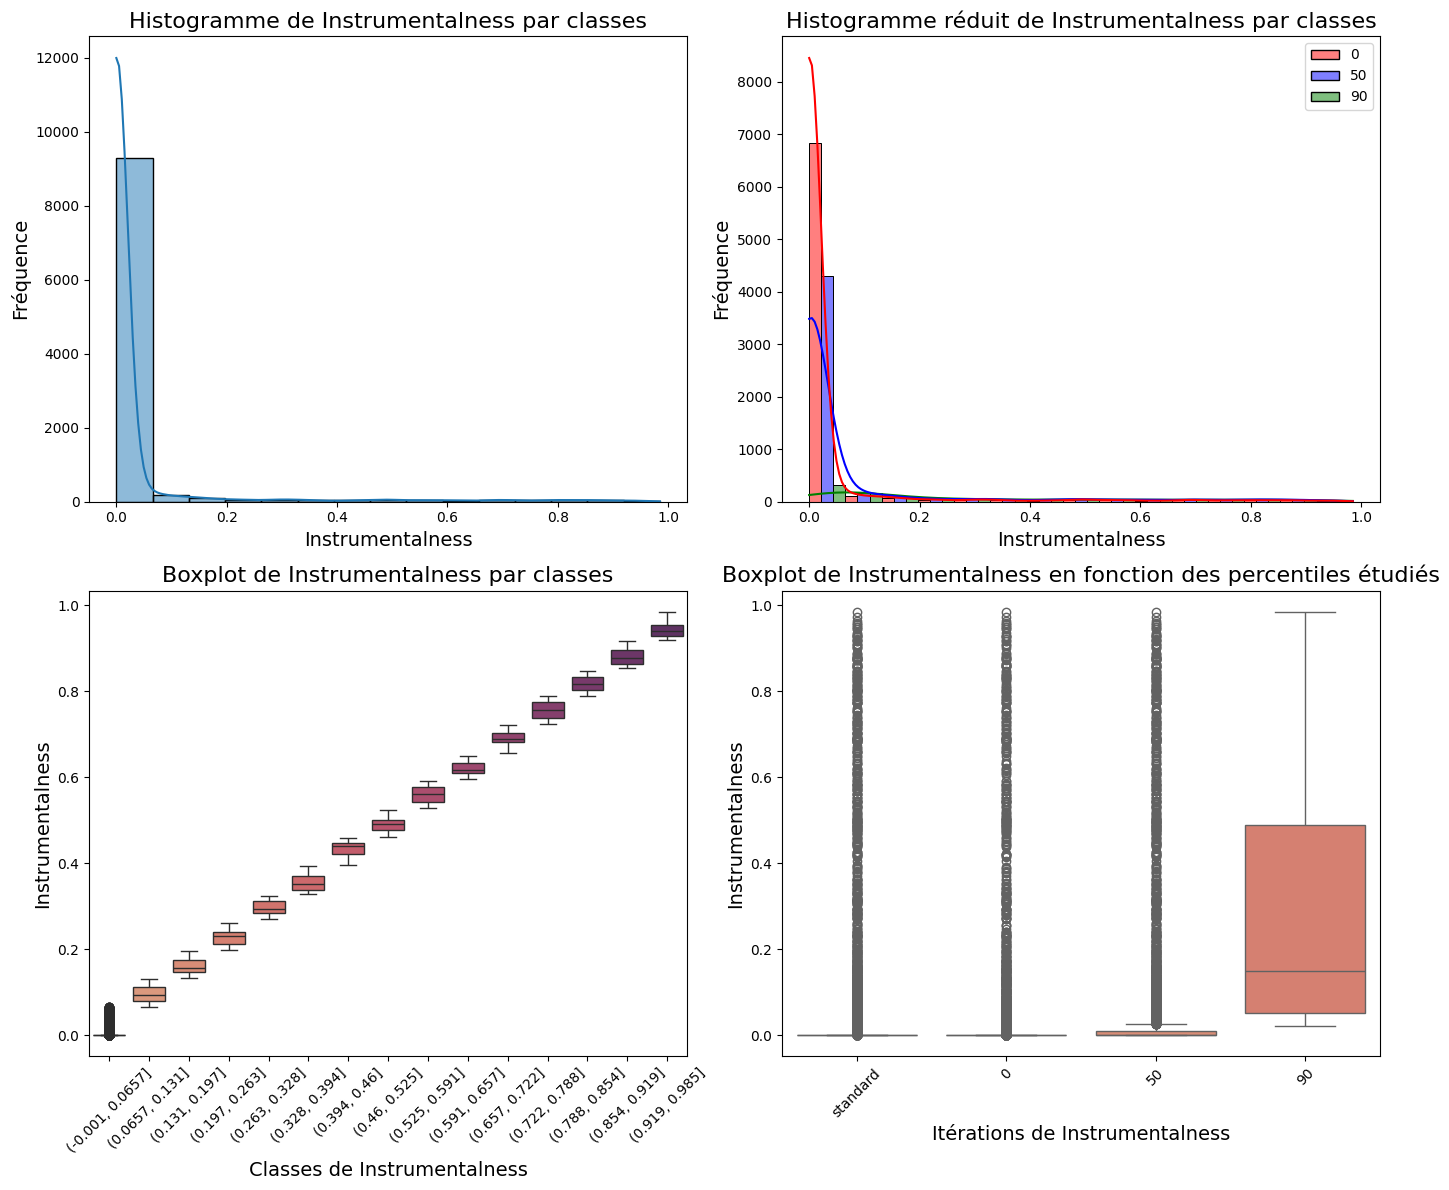

count    9997.000000
mean        0.185777
std         0.149194
min         0.012000
25%         0.089200
50%         0.128000
75%         0.245000
max         0.989000
Name: Liveness, dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'{variable_name}_classe', y=variable_na

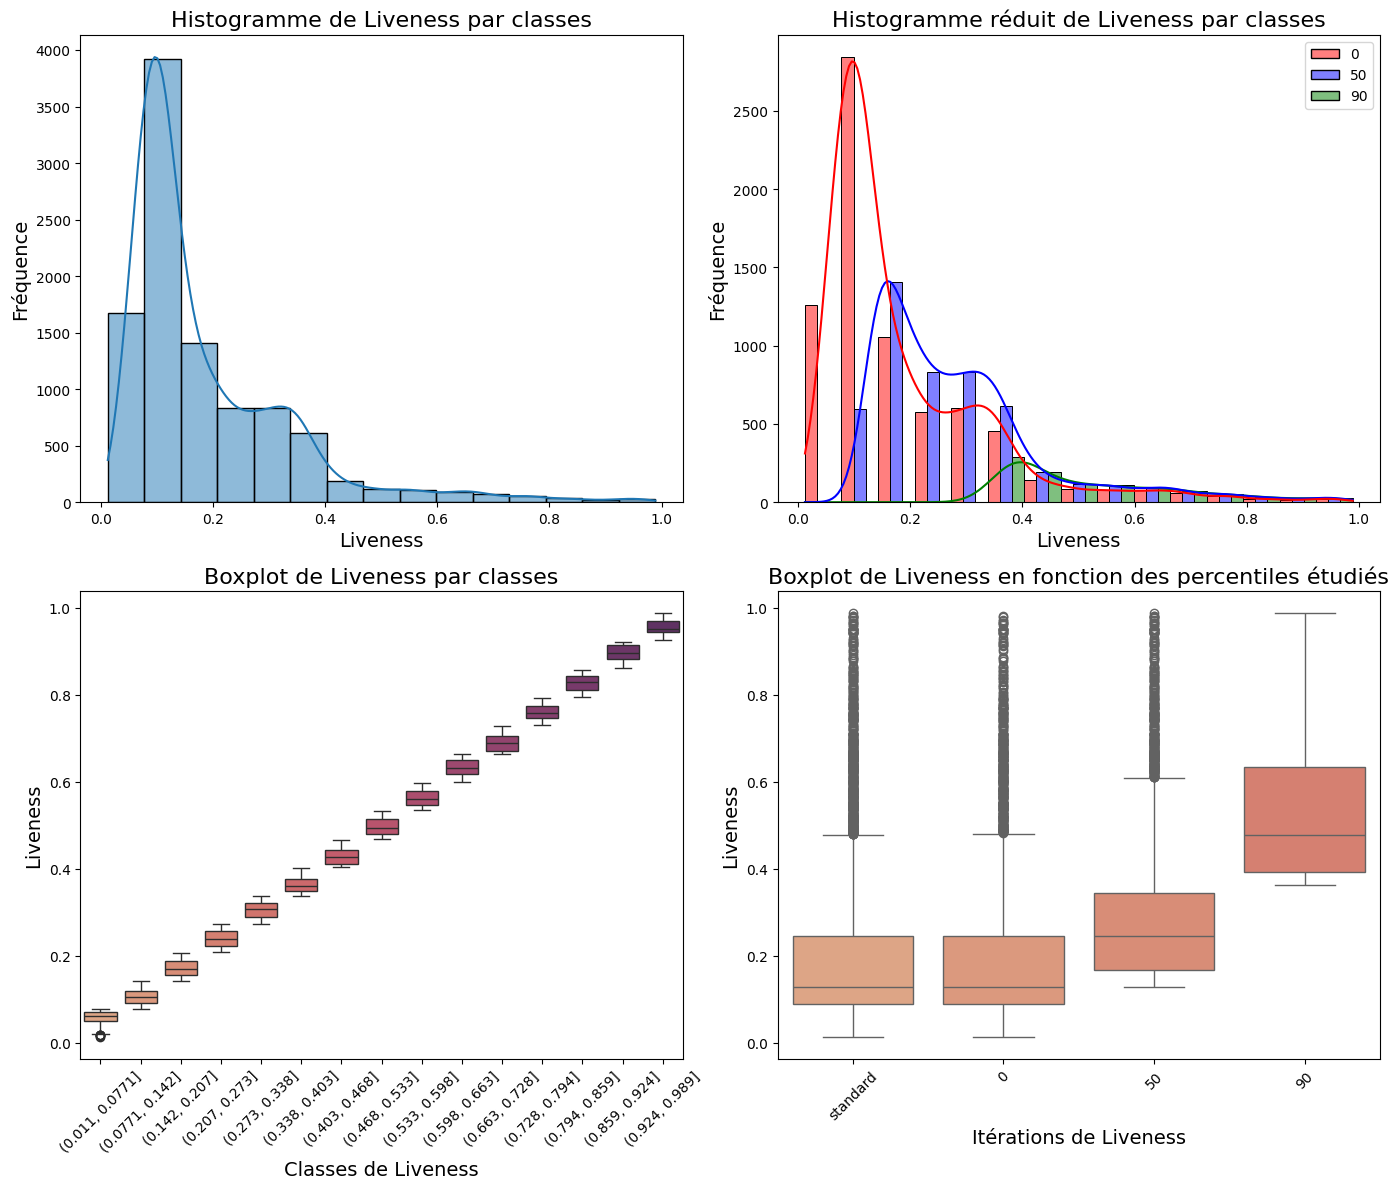

count    9997.000000
mean        0.585459
std         0.239105
min         0.000000
25%         0.398000
50%         0.598000
75%         0.783000
max         0.995000
Name: Valence, dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'{variable_name}_classe', y=variable_na

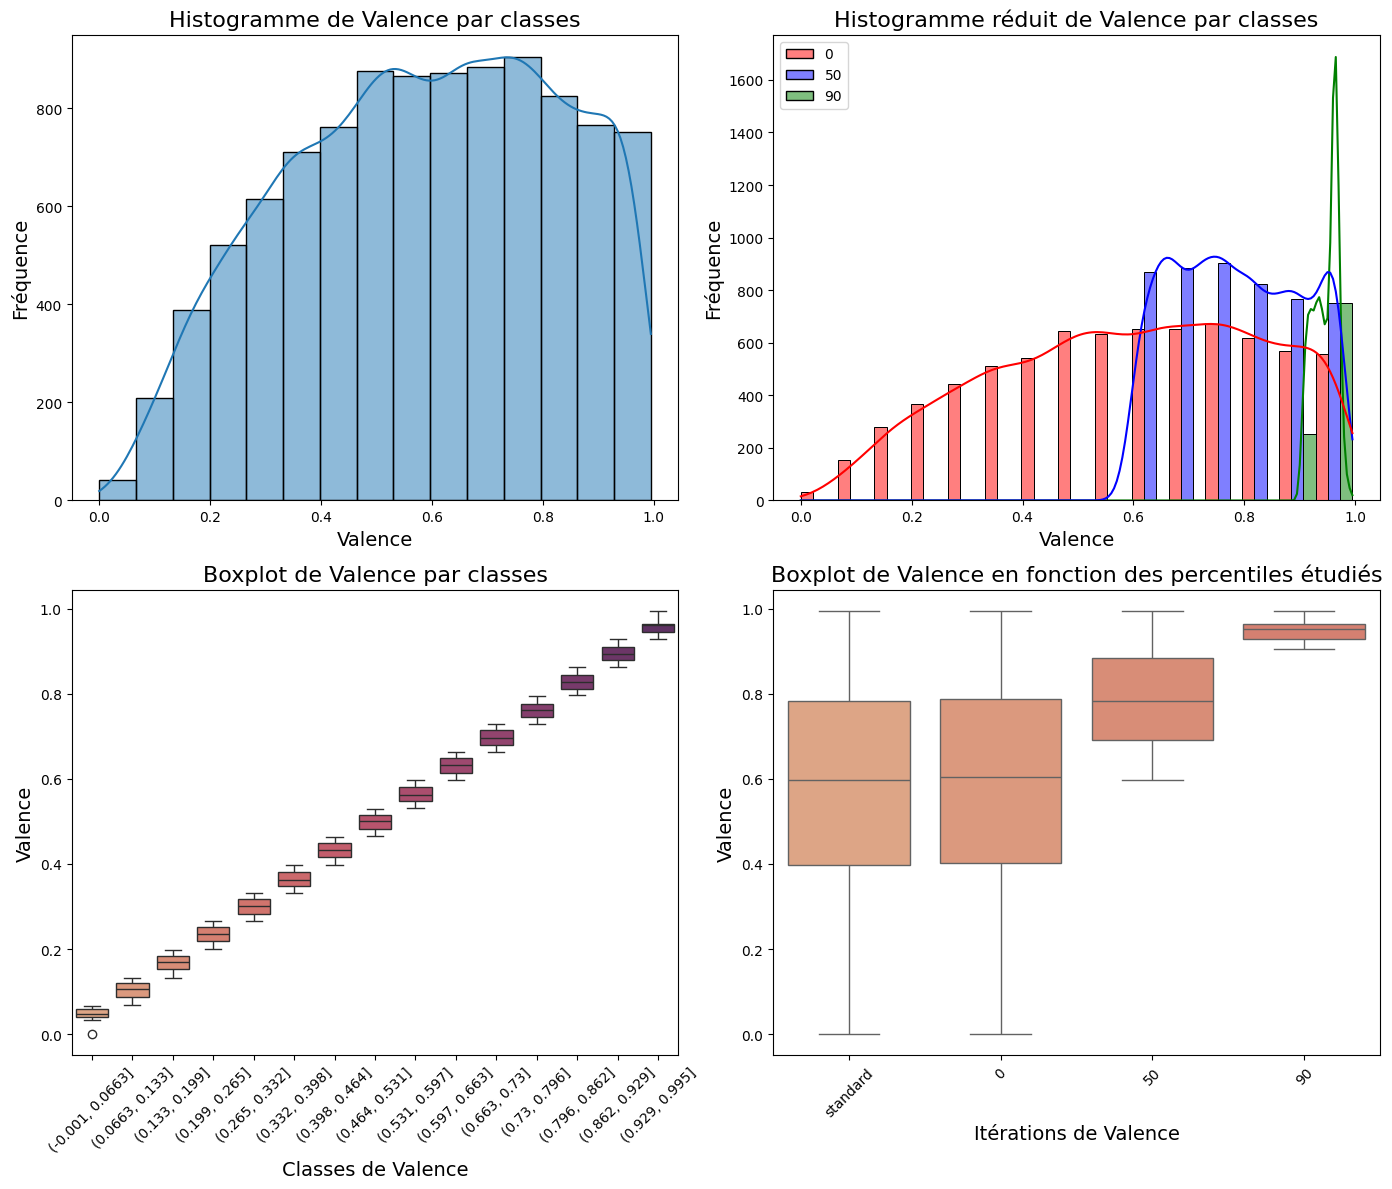

count    9997.000000
mean      121.496650
std        26.260686
min         0.000000
25%       102.642000
50%       120.653000
75%       134.328000
max       217.913000
Name: Tempo, dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'{variable_name}_classe', y=variable_na

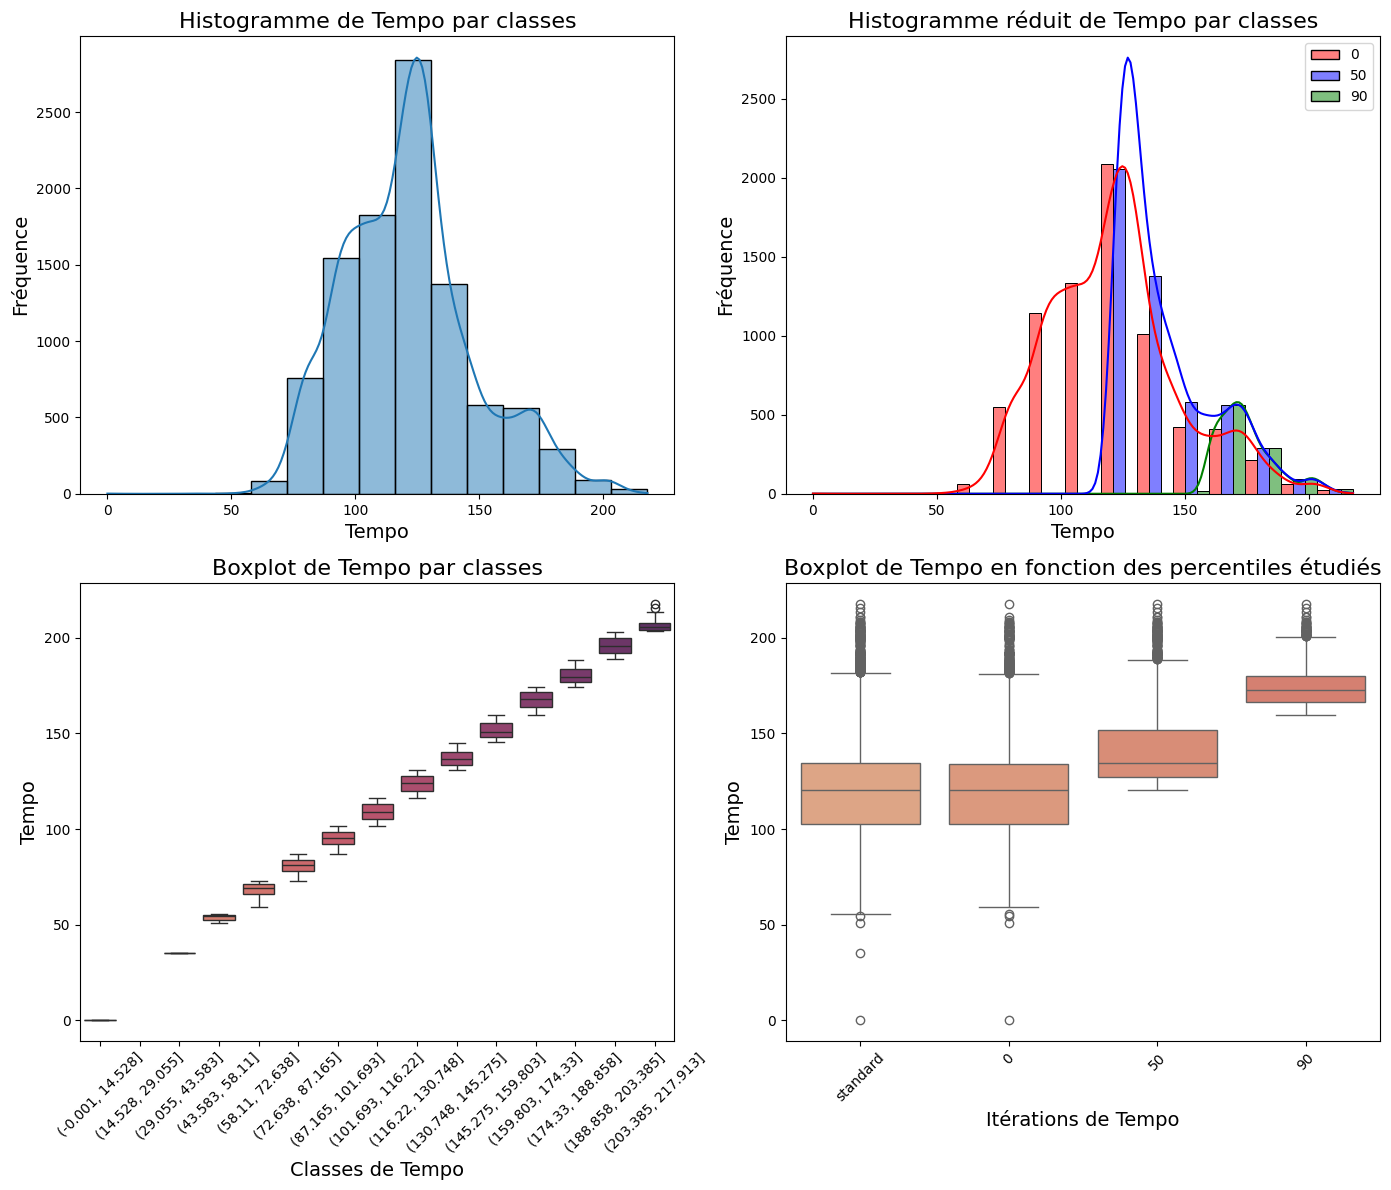

count    9997.000000
mean        3.960488
std         0.250927
min         0.000000
25%         4.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: Time Signature, dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'{variable_name}_classe', y=variable_na

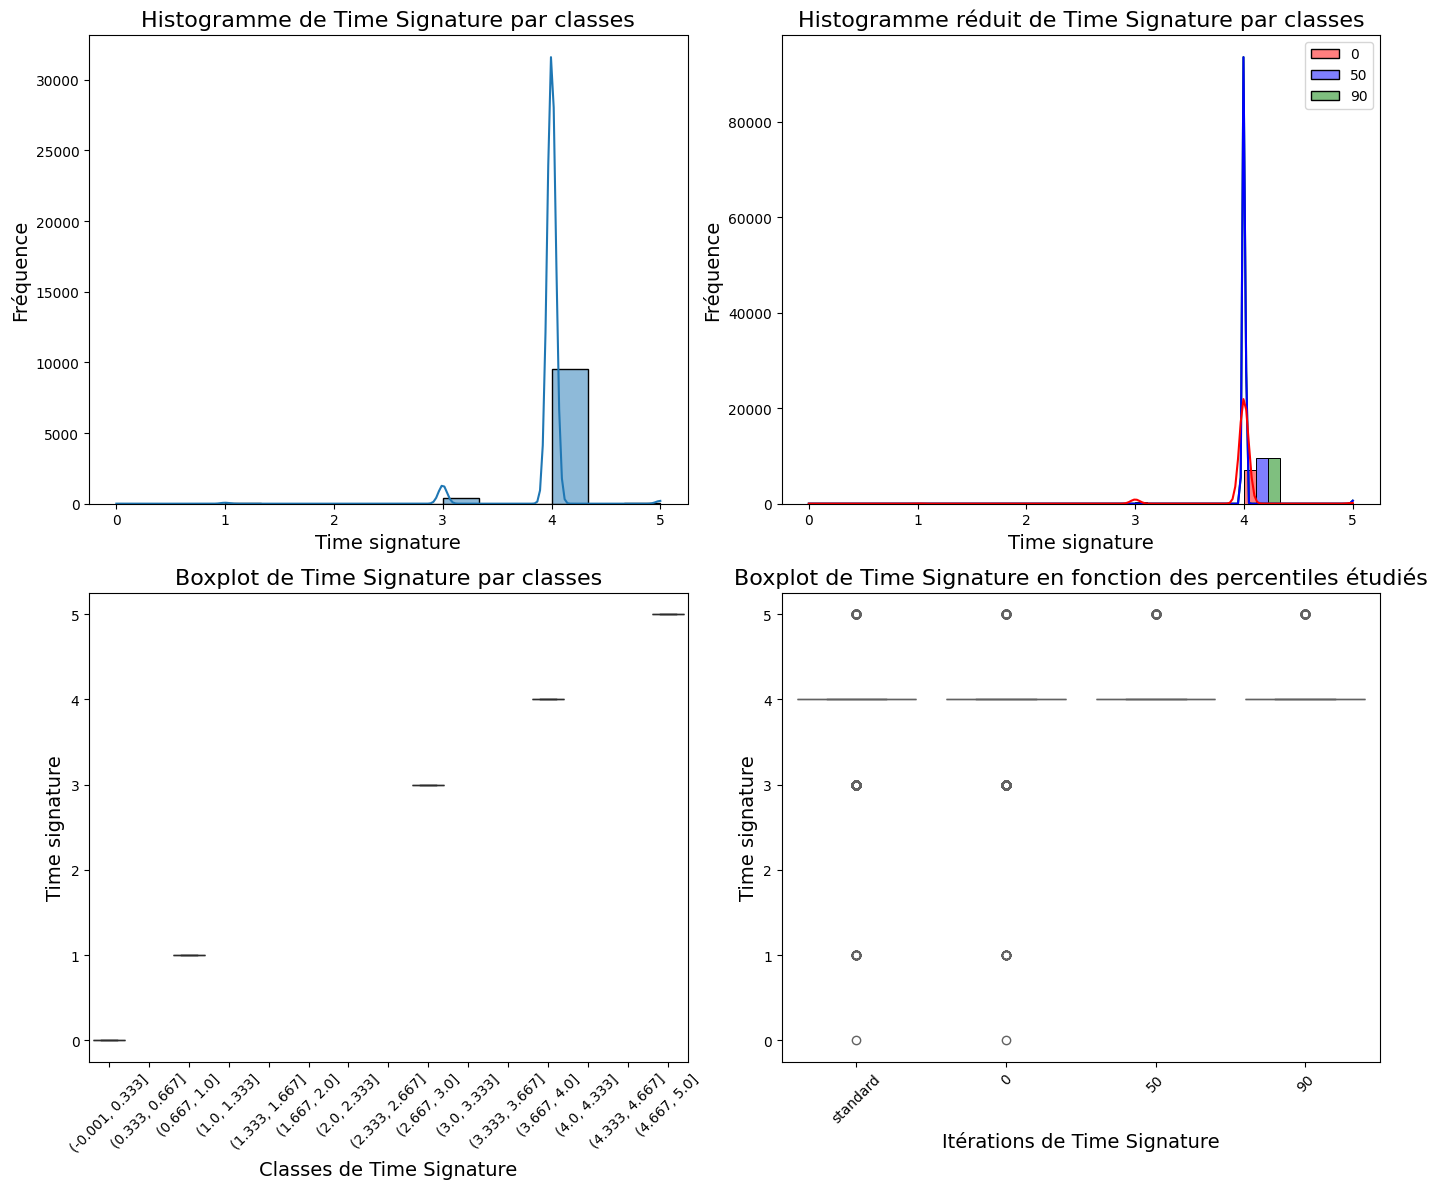

count    9997.000000
mean        0.050915
std         0.219836
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: Explicit, dtype: float64


C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:39: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)
C:\Users\alexa\AppData\Local\Temp\ipykernel_11368\1899224161.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=f'{variable_name}_classe', y=variable_na

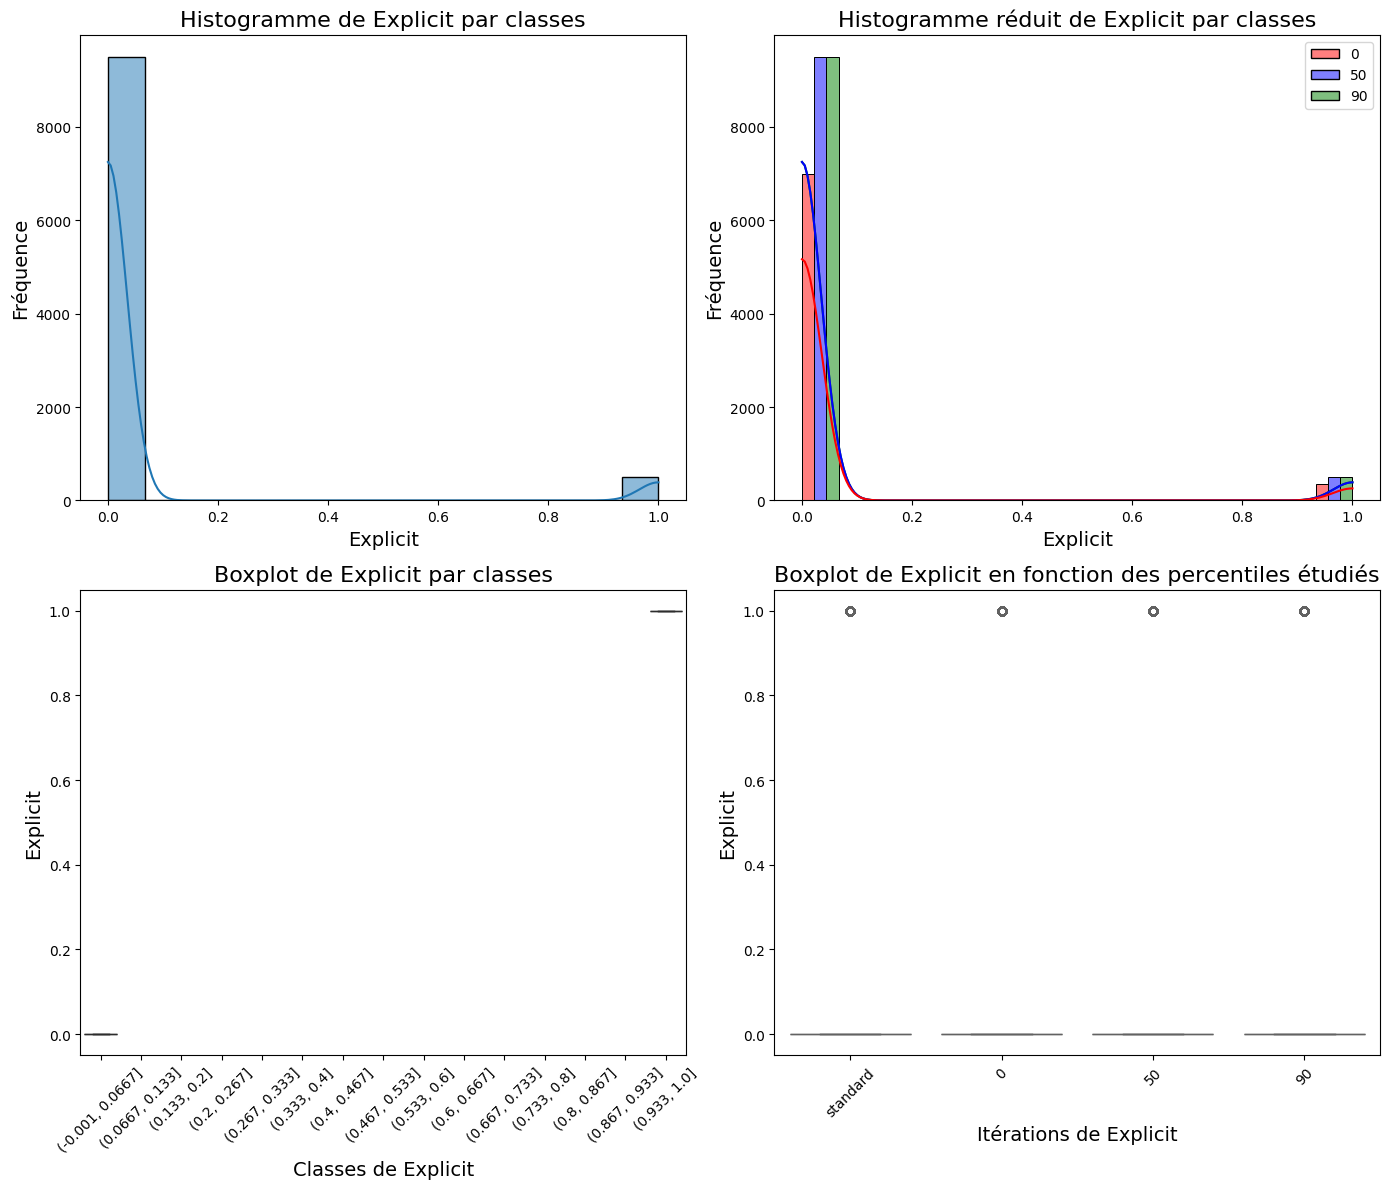

AssertionError: 

In [151]:
def etude_univariee_thresh(data, variable_name, variable_to_compare, K=0):
    
    data_min = data[data[variable_to_compare] >= data[variable_to_compare].min() + 1]  
    
    limite_middle = data[variable_name].quantile(0.50)
    data_middle = data[data[variable_name] >= limite_middle]
    limite_top = data[variable_name].quantile(0.90)
    data_top = data[data[variable_name] >= limite_top]
    
    restricted_df = pd.DataFrame({"0": data_min[variable_name], "50": data_middle[variable_name], "90": data_top[variable_name]})

    
    print(data[variable_name].describe())
    
    plt.show()
    
    def calculate_bins(data_column, num_classes):
        n = len(data_column)  # Size of the population
        if num_classes == 0:  # If K is not specified by the user
            num_classes = int(np.ceil(1 + np.log2(n)))  # Number of classes according to the Sturges formula
        e = data_column.max() - data_column.min()  # Range
        bins = np.linspace(data_column.min(), data_column.max(), num_classes + 1)  # Bins for distribution
        return bins

    # Calcul des bins pour la variable choisie
    bins = calculate_bins(data[variable_name].dropna(), K)  # Supprimer les NaN pour calculer les bins

    # Assignation des classes aux données
    data[f'{variable_name}_classe'] = pd.cut(data[variable_name], bins=bins, include_lowest=True)
    data_min[f'{variable_name}_classe'] = pd.cut(data_min[variable_name], bins=bins, include_lowest=True)

    # Choix d'une palette de couleurs
    palette = sns.color_palette("flare", n_colors=len(bins))

    # Visualisations détaillées pour la variable choisie avec répartition en classes
    fig, ax = plt.subplots(2, 2, figsize=(14, 12))

    # Histogramme de la variable avec classes
    sns.histplot(data, x=variable_name, bins=bins, kde=True, ax=ax[0,0], palette=palette)  
    ax[0,0].set_title(f"Histogramme de {variable_name} par classes", fontsize=16)
    ax[0,0].set_xlabel(f"{variable_name.capitalize()}", fontsize=14)
    ax[0,0].set_ylabel('Fréquence', fontsize=14)
    
    sns.histplot(restricted_df, bins=bins, kde=True, ax=ax[0,1], palette=["red", "blue", "green"], multiple="dodge")
    #sns.histplot(data_min, x=variable_name, bins=bins, kde=True, ax=ax[0,1], color = "blue", multiple="stack")
    #sns.histplot(data_middle, x=variable_name, bins=bins, kde=True, ax=ax[0,1], color = "green", multiple="dodge")
    #sns.histplot(data_top, x=variable_name, bins=bins, kde=True, ax=ax[0,1], color = "red", multiple="dodge") 
    ax[0,1].set_title(f"Histogramme réduit de {variable_name} par classes", fontsize=16)
    ax[0,1].set_xlabel(f"{variable_name.capitalize()}", fontsize=14)
    ax[0,1].set_ylabel('Fréquence', fontsize=14)

    # Boîte à moustaches pour la variable avec classes
    sns.boxplot(x=f'{variable_name}_classe', y=variable_name, data=data, ax=ax[1,0], palette=palette)
    ax[1,0].set_title(f"Boxplot de {variable_name} par classes", fontsize=16)
    ax[1,0].set_xlabel(f"Classes de {variable_name}", fontsize=14)
    ax[1,0].set_ylabel(f"{variable_name.capitalize()}", fontsize=14)
    ax[1,0].tick_params(axis='x', rotation=45) 

    restricted_df_box = pd.DataFrame( {"standard": data[variable_name],"0": data_min[variable_name], "50": data_middle[variable_name], "90": data_top[variable_name]} )

    sns.boxplot( data=restricted_df_box, palette=palette, ax=ax[1,1])
    
    ax[1,1].set_title(f"Boxplot de {variable_name} en fonction des percentiles étudiés", fontsize=16)
    ax[1,1].set_xlabel(f"Itérations de {variable_name}", fontsize=14)
    ax[1,1].set_ylabel(f"{variable_name.capitalize()}", fontsize=14)    
    ax[1,1].tick_params(axis='x', rotation=45) 

    plt.tight_layout()
    plt.show()  
    

for column in donnees.columns:
    etude_univariee_thresh(donnees, column, "Popularity") 